## Loading of Libraries 
Preceeding analysis of the dataset, the necessary libraries must be loaded. Additionally, a seed will be set so that the analysis performed can be reproduced.

In [1]:
# libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("kknn")
library(kknn)
install.packages("rsample")
library(rsample)
install.packages("GGally")
library(GGally)
install.packages("themis")
library(themis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
#setting seed
set.seed(2020)

## Reading Data Set
* briefly explain columns (variable name, units) in data set and how it will be read
* include test to see if there is any missing data in the set before analysis can continue
* explain that we changed the range of diagnosis (num) to [0,1] from [0,4] to differentiate clear cases of heart disease (1) from cases of no heart disease (0), makes our analysis cleaner (can assign Diagnosed/Not diagnosed labels)
* include summary of the amount of patients diagnosed vs undiagnosed to show the balance between the two and to show the scale of the dataset (e.g: analysis is limited to number of participants in study)

**Table 1: Cleveland Heart Disease Data**

In [3]:
# importing in data and adding column names
data <- read_csv("https://raw.githubusercontent.com/BeesKneezz/dsci_100_2023_group_7/main/data/processed.cleveland.data", col_names = FALSE)
colnames(data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [4]:
#Ensure there is no missing data
test_missing <- sum(is.na(data))
tibble(test_missing)

test_missing
<int>
0


In [5]:
#changing Diagnosis from numerical to factorial (num) range [0,4] -> [0,1]
data_new <- data |>
mutate("diagnosis" = as_factor(num))
data_new$diagnosis[data_new$diagnosis != '0'] <- '1'
data_new <- droplevels(data_new)
data_new

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3,1
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0,0


In [6]:
#summary of data set 
observations <- data_new |>
select(diagnosis) |>
group_by(diagnosis) |>
summarize(count = n())

observations

diagnosis,count
<fct>,<int>
0,164
1,139


## Further Data Wrangling: Choosing Predictors Based off Research
**!!will elaborate!!**
* 13 variables in data set
* Question focuses on factors we can control
* can control: trestbps, chol, fbs, thalach (cite sources)
* will select these four predictors for preliminary analysis
* use ggpairs to visualize relationship of variables with each other to see how each factor impacts one another

In [7]:
#selection of preliminary predictors
data_wrangled <- data_new |>
select(trestbps, chol, fbs, thalach, diagnosis)
    #   chol: serum cholestoral in mg/dl
    #   trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    #   thalach: maximum heart rate achieved
    #   fbs: fasting blood sugar
    #   --  Value 0: fasting blood sugar < 120 mg/dl
    #   --  Value 1: fasting blood sugar > 120 mg/dl
    #   diagnosis: diagnosis of heart disease (angiographic disease status)
    #    -- Value 0: < 50% diameter narrowing
    #    -- Value 1: > 50% diameter narrowing
data_wrangled

trestbps,chol,fbs,thalach,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
145,233,1,150,0
160,286,0,108,1
120,229,0,129,1
⋮,⋮,⋮,⋮,⋮
130,131,0,115,1
130,236,0,174,1
138,175,0,173,0


In [8]:
# # filtering / wrangling data
# data_wrangled <- data_new |>  
#     #   chol: serum cholestoral in mg/dl
#     #   trestbps: resting blood pressure (in mm Hg on admission to the hospital)
#     #   thalach: maximum heart rate achieved
#     #   fbs: fasting blood sugar
#     #   --  Value 0: fasting blood sugar < 120 mg/dl
#     #   --  Value 1: fasting blood sugar > 120 mg/dl
#     #   num: diagnosis of heart disease (angiographic disease status)
#     #    -- Value 0: < 50% diameter narrowing
#     #    -- Value 1: > 50% diameter narrowing
#     select(fbs, chol, trestbps, thalach, diagnosis) |>
#     mutate(diagnosis = as_factor(num))
# data_wrangled$diagnosis[data_wrangled$diagnosis != '0'] <- '1'
# data_wrangled <- droplevels(data_wrangled)
# # levels(data_wrangled$num) <- c(levels(data_wrangled$num), 'Diagnosed', 'Not diagnosed')
# # data_wrangled$num[data_wrangled$num != '0'] <- 'Diagnosed'
# # data_wrangled$num[data_wrangled$num == '0'] <- 'Not diagnosed'
# data_wrangled

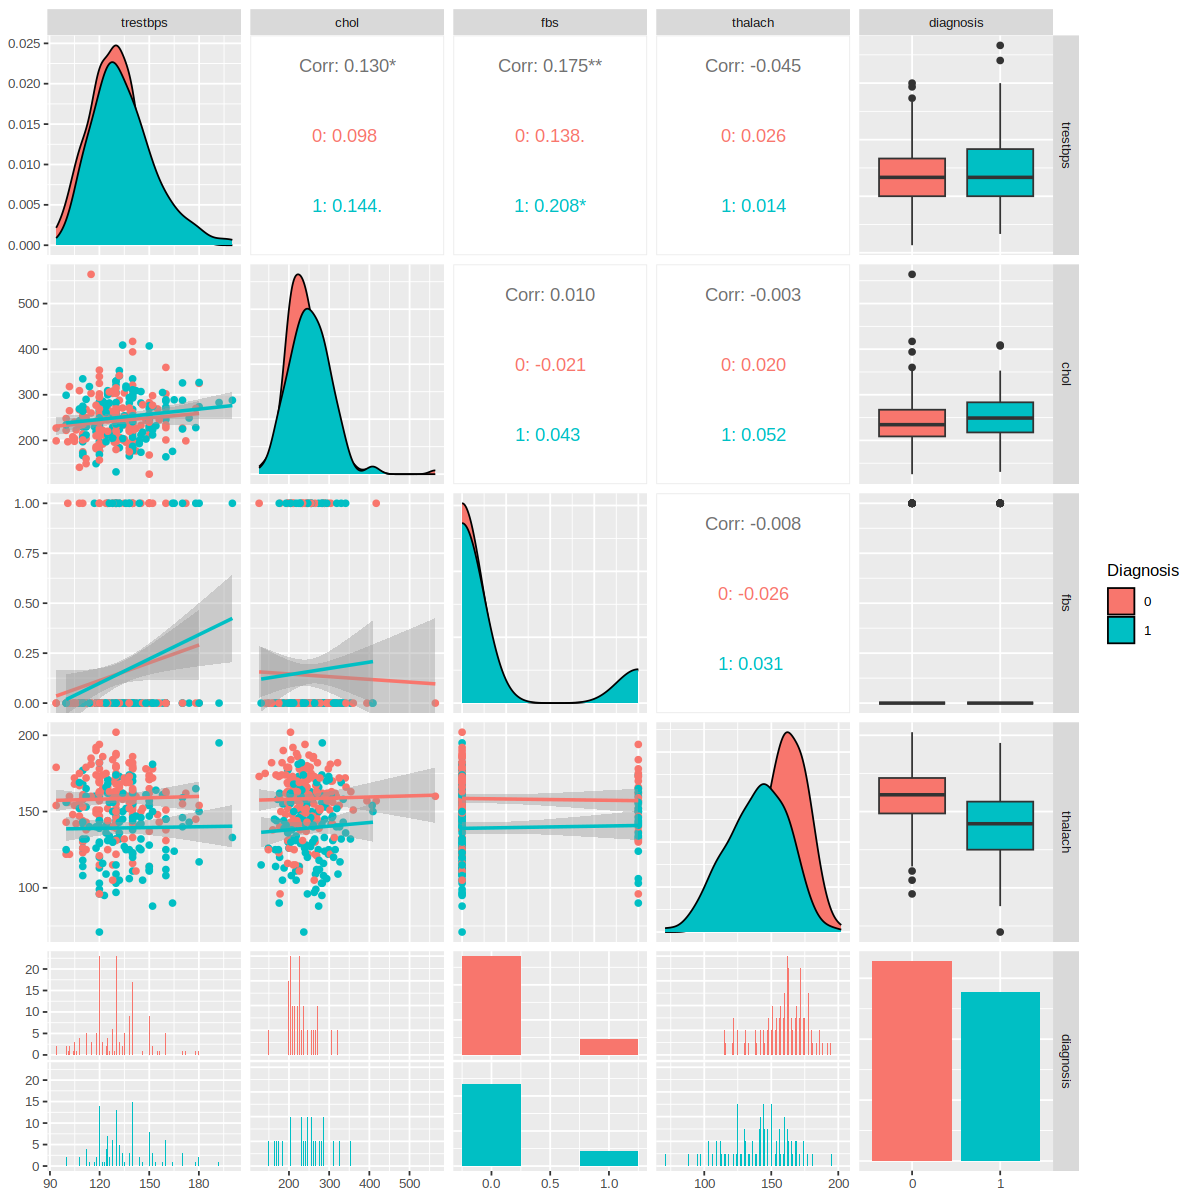

In [9]:
# using ggpairs for visualization of chosen predictors against one another
options(repr.plot.width=10, repr.plot.height=10)
wrangled_plots <- ggpairs(data_wrangled,
  columnLabels = c("trestbps", "chol", "fbs", "thalach", "diagnosis" ),
  mapping = aes(color = diagnosis),
  legend = 1,
  lower = list(combo=wrap("facethist",  binwidth=0.5), continuous = "smooth"),
  diag = list(continuous = "densityDiag")) +
  theme(text = element_text(size = 10)) +
  labs(fill = "Diagnosis")
wrangled_plots

## Data Analysis: Accuracy of Selected Predictors 
* determined the accuracy of the chosen predictors when diagnosing heart disease
* explain step by step process of how accuracy was found and why we chose to find it using classification (splitting data, creating recipe/finding neighbours, cross validation, etc..)
* explain the determined accuracy post-analysis. Since our initial research corroborated our variable selection, this means we must analyze our variables further to narrow down which of the 4 that we chose is decreasing the accuracy so we can answer our research question. 

In [10]:
# splitting data sets
data_split <- initial_split(data_wrangled, prop = 0.75, strata = diagnosis)
data_train <- training(data_split)
data_test <- testing(data_split)

In [11]:
recipe <- recipe(diagnosis ~ ., data = data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification") 

vfold <- vfold_cv(data_train, v = 5, strata = diagnosis)

fit <- workflow() |>
    add_recipe(recipe) |> 
    add_model(model) |>
    tune_grid(resamples = vfold, grid = tibble(neighbors = seq(from = 1, to = 100, by = 5)))

In [12]:
metrics <- fit |>
    collect_metrics() |>
    filter(.metric == 'accuracy')

tuned_K <-  metrics |>
    filter(mean == max(mean)) |>
    select(neighbors) |>
    pull()

metrics
tuned_K

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5944005,5,0.02410374,Preprocessor1_Model01
6,accuracy,binary,0.6158498,5,0.03122307,Preprocessor1_Model02
11,accuracy,binary,0.6164383,5,0.02148937,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,binary,0.6525033,5,0.01630219,Preprocessor1_Model18
91,accuracy,binary,0.6613000,5,0.01955262,Preprocessor1_Model19
96,accuracy,binary,0.6613000,5,0.01955262,Preprocessor1_Model20


[1] 36

In [14]:
tuned_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tuned_K) |>
    set_engine("kknn") |>
    set_mode("classification") 

fit <- workflow() |>
    add_recipe(recipe) |> 
    add_model(tuned_model) |>
    fit_resamples(resamples = vfold)

In [22]:
metrics <- fit |>
    collect_metrics() |>
    filter(.metric == 'accuracy')

metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6959816,5,0.01280948,Preprocessor1_Model1


In [32]:
test_fit <- workflow() |>
    add_recipe(recipe) |> 
    add_model(tuned_model) |>
    fit(data = data_test)

predictions <- predict(test_fit, data_test) |>
    bind_cols(data_test)

matrix <- predictions |>
    conf_mat(truth = diagnosis, estimate = .pred_class)

test_metrics <- predictions |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy")

matrix
test_metrics

          Truth
Prediction  0  1
         0 38 26
         1  3  9

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6184211


## Using forward selection

In [35]:
names <- colnames(data_train |> select(-diagnosis))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
heart_vfold <- vfold_cv(data_train, v = 5, strata = diagnosis)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("diagnosis", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = data_test) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,diagnosis ~ thalach,0.6916293
2,diagnosis ~ thalach+chol,0.6955819
3,diagnosis ~ thalach+chol+trestbps,0.6604128
4,diagnosis ~ thalach+chol+trestbps+fbs,0.6560650


## Further Investigations: Predictor Narrowing